Lien de téléchargement des données: https://cvml.ista.ac.at/AwA2/        

13GB file : https://cvml.ista.ac.at/AwA2/AwA2-data.zip

In [ ]:
!pip install wandb

In [ ]:
import wandb
wandb.init(project="ResNet")

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import shutil
shutil.copytree('/content/drive/MyDrive/IFT3710/Animals_with_Attributes2/','AWA4')

'AWA4'

In [ ]:
import sys
import cv2 # Pour utiliser open_cv, il faut la version de python est 3.7
import os
import csv

import numpy as np 
import pandas as pd 
import math

import torch 
from torch.utils.data import Dataset, DataLoader
import torchvision 
from torchvision.io import read_image
import torchvision.datasets as datasets
import torchvision.transforms as transforms

np.random.seed(0)

In [ ]:
# Constant. Should be the path to the folder named JPEGImages, containing the 33K images in its subfolders.
# DATA_FOLDER_PATH = "/Users/xiongyuyang/Downloads/Animals_with_Attributes2/"
# JPEGIMAGES_FOLDER_PATH = "/Users/xiongyuyang/Downloads/Animals_with_Attributes2/JPEGImages/"
DATA_FOLDER_PATH = '/content/AWA4/'
JPEGIMAGES_FOLDER_PATH = '/content/AWA4/JPEGImages/'

In [ ]:
from google.colab.patches import cv2_imshow

(755, 1024, 3)
<class 'numpy.ndarray'>


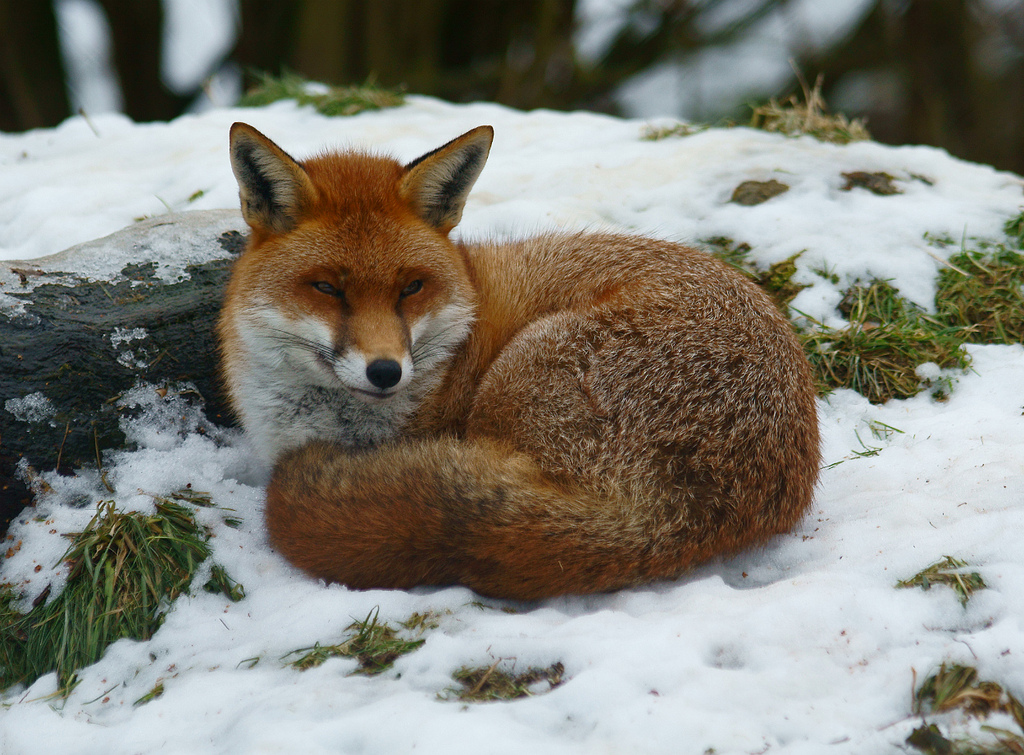

-1

In [ ]:
# quick test
test = JPEGIMAGES_FOLDER_PATH+"fox/fox_10002.jpg"
img = cv2.imread(test) 
print(img.shape) #ndarray
print(type(img))
cv2_imshow(img)
cv2.waitKey(0)

In [ ]:
labels_dirs = os.listdir(JPEGIMAGES_FOLDER_PATH)
labels_dirs = [f for f in labels_dirs if not f.startswith('.')] # remove hidden files
print(labels_dirs)
len(labels_dirs) # 50 labels / subdirectories

['mouse', 'rhinoceros', 'cow', 'chimpanzee', 'skunk', 'chihuahua', 'mole', 'squirrel', 'giant+panda', 'gorilla', 'elephant', 'fox', 'grizzly+bear', 'moose', 'zebra', 'beaver', 'deer', 'rat', 'german+shepherd', 'spider+monkey', 'leopard', 'humpback+whale', 'walrus', 'raccoon', 'dalmatian', 'blue+whale', 'collie', 'rabbit', 'wolf', 'persian+cat', 'hamster', 'buffalo', 'bobcat', 'pig', 'bat', 'horse', 'tiger', 'dolphin', 'seal', 'giraffe', 'hippopotamus', 'lion', 'sheep', 'otter', 'antelope', 'ox', 'siamese+cat', 'polar+bear', 'killer+whale', 'weasel']


50

# Note : Some labels have a low number of images. 

## Possible solutions to explore : 
    Data augmentation : creating new training data by applying random transformations to existing images, such as rotating, cropping, or flipping them.

In [ ]:
def find_num_images_per_label(img_dir = JPEGIMAGES_FOLDER_PATH) -> tuple[dict,dict]: 
    """ 
    USEFUL FOR SAMPLING.
    Return a dict with keys as the 50 labels, and values being the number of images in each subdirectory corresponding to label
    and a second dict with the relative numbers (proportion) for every label compared to the total number of images (useful for sampling)"""
    labels_dirs = os.listdir(img_dir)
    labels_dirs = [f for f in labels_dirs if not f.startswith('.')] # remove hidden files
    num_images_per_label = dict.fromkeys(labels_dirs)
    proportions_images_per_label = dict.fromkeys(labels_dirs)
    total_num_images = 0

    # Update absolute number of images per label
    for i, label in enumerate(labels_dirs) : 
        specific_label_path = os.path.join(img_dir, labels_dirs[i])
        num_images_label = len(os.listdir(specific_label_path))
        total_num_images += num_images_label
        num_images_per_label[label] = num_images_label

    # Update relative number of images per label (proportion)
    for i, label in enumerate(labels_dirs) : 
        num_images_label = num_images_per_label[label]
        proportion_label = round(num_images_label / total_num_images, 4)
        proportions_images_per_label[label] = proportion_label

    return num_images_per_label, proportions_images_per_label

num_images_per_label, proportions_images_per_label = find_num_images_per_label()
print(num_images_per_label)
print(proportions_images_per_label)

{'mouse': 185, 'rhinoceros': 696, 'cow': 1338, 'chimpanzee': 728, 'skunk': 188, 'chihuahua': 567, 'mole': 100, 'squirrel': 1200, 'giant+panda': 874, 'gorilla': 872, 'elephant': 1038, 'fox': 664, 'grizzly+bear': 852, 'moose': 704, 'zebra': 1170, 'beaver': 193, 'deer': 1344, 'rat': 310, 'german+shepherd': 1033, 'spider+monkey': 291, 'leopard': 720, 'humpback+whale': 709, 'walrus': 215, 'raccoon': 512, 'dalmatian': 549, 'blue+whale': 174, 'collie': 1028, 'rabbit': 1088, 'wolf': 589, 'persian+cat': 747, 'hamster': 779, 'buffalo': 904, 'bobcat': 630, 'pig': 713, 'bat': 383, 'horse': 1645, 'tiger': 877, 'dolphin': 946, 'seal': 988, 'giraffe': 1202, 'hippopotamus': 684, 'lion': 1019, 'sheep': 1420, 'otter': 758, 'antelope': 1046, 'ox': 728, 'siamese+cat': 500, 'polar+bear': 868, 'killer+whale': 291, 'weasel': 282}
{'mouse': 0.005, 'rhinoceros': 0.0186, 'cow': 0.0358, 'chimpanzee': 0.0195, 'skunk': 0.005, 'chihuahua': 0.0152, 'mole': 0.0027, 'squirrel': 0.0321, 'giant+panda': 0.0234, 'gorilla'

In [ ]:
ANNOTATIONS_FILENAME = 'annotations.csv'

def create_annotations_csv_file(annotations_filename = ANNOTATIONS_FILENAME, img_dir = JPEGIMAGES_FOLDER_PATH): 
    """ 
    Create a csv annotations_file, annotations.csv, with two columns, in the format : 
                        path/to/image, label
    
    The annotation csv is necessary for DataLoader.
    """
    
    labels_dirs:list = os.listdir(img_dir)
    labels_dirs = [f for f in labels_dirs if not f.startswith('.')] # remove hidden files
   
    if os.path.exists(annotations_filename):
        os.remove(annotations_filename)
        print(f'Deleted existent {ANNOTATIONS_FILENAME} file.\n ---------------------------')
    
    with open(annotations_filename, 'w', newline='') as file :
        writer = csv.writer(file, dialect='excel', delimiter=',')

        for i, label in enumerate(labels_dirs) : 

            specific_label_path = os.path.join(img_dir, label)
            images_names = os.listdir(specific_label_path)

            for j, image_name in enumerate(images_names):
                full_path_to_img= os.path.join(specific_label_path, image_name)
                full_path_to_img= os.path.join(label, image_name)

                row = [full_path_to_img, label]
                writer.writerow(row)

    print(f'Sucessfully created {ANNOTATIONS_FILENAME} file.')

#
create_annotations_csv_file()

Sucessfully created annotations.csv file.


In [ ]:
# labels_in_number = pd.read_csv(DATA_FOLDER_PATH+"classes.txt", delim_whitespace=True,header=None)
labels_dict = {}
with open(DATA_FOLDER_PATH+"classes.txt") as f:
    for line in f:
        # print(line.split())
        (key,val) = line.split()
        labels_dict[val] = int(key)-1
print(labels_dict)

{'antelope': 0, 'grizzly+bear': 1, 'killer+whale': 2, 'beaver': 3, 'dalmatian': 4, 'persian+cat': 5, 'horse': 6, 'german+shepherd': 7, 'blue+whale': 8, 'siamese+cat': 9, 'skunk': 10, 'mole': 11, 'tiger': 12, 'hippopotamus': 13, 'leopard': 14, 'moose': 15, 'spider+monkey': 16, 'humpback+whale': 17, 'elephant': 18, 'gorilla': 19, 'ox': 20, 'fox': 21, 'sheep': 22, 'seal': 23, 'chimpanzee': 24, 'hamster': 25, 'squirrel': 26, 'rhinoceros': 27, 'rabbit': 28, 'bat': 29, 'giraffe': 30, 'wolf': 31, 'chihuahua': 32, 'rat': 33, 'weasel': 34, 'otter': 35, 'buffalo': 36, 'zebra': 37, 'giant+panda': 38, 'deer': 39, 'bobcat': 40, 'pig': 41, 'lion': 42, 'mouse': 43, 'polar+bear': 44, 'collie': 45, 'walrus': 46, 'raccoon': 47, 'cow': 48, 'dolphin': 49}


In [ ]:
class AWA2Dataset(Dataset): # Dataset class to serve as input for the DataLoader.
    """ 
    Dataset class to serve as input for the DataLoader.
    Implements all the required methods and more. 
    """

    def __init__(self, annotations_file=ANNOTATIONS_FILENAME, img_dir=JPEGIMAGES_FOLDER_PATH, 
                transform=None, target_transform=None):
        self.img_labels = pd.read_csv(annotations_file)
        self.img_dir = img_dir
        self.transform = transform
        self.target_transform = target_transform

        numbers_infos_dicts: tuple[dict,dict] = find_num_images_per_label(img_dir=JPEGIMAGES_FOLDER_PATH)
        self.num_images_per_label = numbers_infos_dicts[0]
        self.proportions_images_per_label = numbers_infos_dicts[1]

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_labels.iloc[idx, 0])
        # img_path = self.img_labels.iloc[idx, 0]
        key = self.img_labels.iloc[idx, 1]

        # Mapping the labels from string to tensor
        label = labels_dict[key]

        image = read_image(img_path)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

In [ ]:
dataset = AWA2Dataset()
image,label = dataset[4125]
print(label) #
print(image.shape)#
print(image)#
print(len(dataset))#

## TODO : Change transforms. Currently this is not useful.
dataset.transform = transforms.Compose([
                    transforms.ToPILImage(),
                    transforms.Resize(256),
                    transforms.CenterCrop(224),
                    transforms.Grayscale(num_output_channels=3),
                    transforms.ToTensor(), # Already a tensor as implemented in Dataset class with the reaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaaa
                    # transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
                    transforms.Normalize(mean = [0.4643, 0.4640, 0.3985] , std=[0.2521, 0.2425, 0.2538])
                ])

# Testing. All good
# random_index = np.random.randint(0, len(dataset))
# image, label = dataset[1]
# print(label)
# print(image)
train_size =  int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size,test_size])

26
torch.Size([3, 678, 1024])
tensor([[[158, 159, 162,  ...,  27,  28,  27],
         [158, 159, 163,  ...,  23,  30,  29],
         [158, 159, 163,  ...,  22,  29,  29],
         ...,
         [  7,   6,   5,  ...,   2,   0,   0],
         [  6,   6,   6,  ...,   6,   3,   2],
         [  7,   6,   6,  ...,   5,  10,  14]],

        [[194, 195, 196,  ...,  61,  62,  61],
         [194, 195, 197,  ...,  60,  64,  63],
         [194, 195, 196,  ...,  59,  63,  63],
         ...,
         [ 37,  36,  32,  ...,  19,  16,  16],
         [ 36,  36,  33,  ...,  20,  20,  19],
         [ 37,  36,  33,  ...,  19,  25,  29]],

        [[  0,   1,   0,  ...,  11,  11,  10],
         [  0,   1,   0,  ...,   9,  13,  12],
         [  0,   1,   1,  ...,   8,  12,  12],
         ...,
         [  0,   0,   0,  ...,   1,   0,   0],
         [  0,   0,   0,  ...,   3,   2,   1],
         [  1,   0,   0,  ...,   2,   6,   8]]], dtype=torch.uint8)
37340


In [ ]:
# Experiment with DataLoader. Everything works good
dataloader = DataLoader(dataset = dataset, batch_size=4, shuffle=True)
dataiter = iter(dataloader)
data = next(dataiter)

images, labels = data 
#print(dataloader)#
print(labels, images.shape)
#print(labels)

tensor([28,  6,  6, 20]) torch.Size([4, 3, 224, 224])


In [ ]:
# Training loop example
num_epochs = 2 
batch_size = 4
total_samples = len(dataset)
n_iterations = math.ceil(total_samples/batch_size)
print(total_samples, n_iterations)

dataloader = DataLoader(dataset = dataset, batch_size=batch_size, shuffle=True)

for epoch in range(num_epochs) : 
    # loop over trainloader 
    for i, (inputs, labels) in enumerate(dataloader) : 
        
        # Do forward and backward pass, update the weights 
        if(i+1) % 5 == 0 :
            print(f'epoch {epoch+1} / {num_epochs}, step, {i+1}/{n_iterations}, inputs {inputs.shape}')

        if i==20 : 
            print('Completed')
            break


37340 9335
epoch 1 / 2, step, 5/9335, inputs torch.Size([4, 3, 224, 224])
epoch 1 / 2, step, 10/9335, inputs torch.Size([4, 3, 224, 224])
epoch 1 / 2, step, 15/9335, inputs torch.Size([4, 3, 224, 224])
epoch 1 / 2, step, 20/9335, inputs torch.Size([4, 3, 224, 224])
Completed
epoch 2 / 2, step, 5/9335, inputs torch.Size([4, 3, 224, 224])
epoch 2 / 2, step, 10/9335, inputs torch.Size([4, 3, 224, 224])
epoch 2 / 2, step, 15/9335, inputs torch.Size([4, 3, 224, 224])
epoch 2 / 2, step, 20/9335, inputs torch.Size([4, 3, 224, 224])
Completed


In [ ]:
from torchvision import models
# resnet = models.resnet18(pretrained=True)
resnet = models.resnet34(pretrained=True)
print(resnet)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU is not available, using CPU")

GPU is available


In [ ]:
import torch.nn as nn
    
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle= True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle= True)

model = resnet

model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 20
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # Print training statistics
        if (i+0) % 100 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_dataloader)}], Loss: {loss.item():.4f}")


Epoch [1/20], Step [1/467], Loss: 11.2191
Epoch [1/20], Step [101/467], Loss: 1.6003
Epoch [1/20], Step [201/467], Loss: 1.4831
Epoch [1/20], Step [301/467], Loss: 1.3288
Epoch [1/20], Step [401/467], Loss: 1.0219
Epoch [2/20], Step [1/467], Loss: 0.8601
Epoch [2/20], Step [101/467], Loss: 1.0664
Epoch [2/20], Step [201/467], Loss: 0.6699
Epoch [2/20], Step [301/467], Loss: 0.6274
Epoch [2/20], Step [401/467], Loss: 0.8260
Epoch [3/20], Step [1/467], Loss: 0.3808
Epoch [3/20], Step [101/467], Loss: 0.5662
Epoch [3/20], Step [201/467], Loss: 0.5102
Epoch [3/20], Step [301/467], Loss: 0.7359
Epoch [3/20], Step [401/467], Loss: 0.5767
Epoch [4/20], Step [1/467], Loss: 0.5016
Epoch [4/20], Step [101/467], Loss: 0.2852
Epoch [4/20], Step [201/467], Loss: 0.5531
Epoch [4/20], Step [301/467], Loss: 0.5602
Epoch [4/20], Step [401/467], Loss: 0.2344
Epoch [5/20], Step [1/467], Loss: 0.3601
Epoch [5/20], Step [101/467], Loss: 0.1505
Epoch [5/20], Step [201/467], Loss: 0.3342
Epoch [5/20], Step [

KeyboardInterrupt: ignored

In [ ]:
resnet.eval()  # switch to evaluation mode

with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels.to(device)


        outputs = resnet(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        print('Accuracy of the model on the test images: {:.2f}%'.format(100 * correct / total))

NameError: ignored